In [1]:
import sys
import importlib
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
base_path = "../src/"
sys.path.append(base_path)
import models
import train
from losses import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#datafilename='../../DATA/data_L25LH_TNG.hdf5'
datafilename='../../DATA/data_L50_TNG_v3.hdf5'
with h5py.File(datafilename, 'r') as f:
    print("Datasets available:")
    for key in f.keys():
        print(key)

with h5py.File(datafilename, 'r') as f:
    #Parameters = f['Parameters'][0, :1024].T.reshape(-1, 1)
    Parameters = f['Parameters'][:, :1024].T
logflag = np.array([False, False, True, True, True, True, False, False, False, True, True, False, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True])
logflag = logflag[:Parameters.shape[1]]
origParameters = Parameters
if not np.all(Parameters[:, logflag] > 0):
    raise ValueError("Some values to be logged are non-positive.")
PartiallyLoggedParameters = Parameters.copy()
PartiallyLoggedParameters[:, logflag] = np.log(PartiallyLoggedParameters[:, logflag])
means = PartiallyLoggedParameters.mean(axis=0)
stds = PartiallyLoggedParameters.std(axis=0)
Parameters = (PartiallyLoggedParameters - means) / stds

with h5py.File(datafilename, 'r') as f:
    Ms_Mh_s90 = f['Ms_Mh_s90'][:].T
    Ms_Mh_s61 = f['Ms_Mh_s61'][:].T
    MBH_Mh_s90 = f['MBH_Mh_s90'][:].T
    MBH_Mh_s61 = f['MBH_Mh_s61'][:].T
    Mg_Mh_s90 = f['Mg_Mh_s90'][:].T
    Mg_Mh_s61 = f['Mg_Mh_s61'][:].T
    Rs_Ms_s90 = f['Rs_Ms_s90'][:].T
    Rs_Ms_s61 = f['Rs_Ms_s61'][:].T
    SFR_Ms_s90 = f['SFR_Ms_s90'][:].T
    SFR_Ms_s61 = f['SFR_Ms_s61'][:].T
    Zs_Ms_s90 = f['Zs_Ms_s90'][:].T
    Zs_Ms_s61 = f['Zs_Ms_s61'][:].T
    SFRH_100Myr = f['SFRH_100Myr'][:].T

Datasets available:
MBH_Mh_s61
MBH_Mh_s90
Mg_Mh_s61
Mg_Mh_s90
Ms_Mh_s61
Ms_Mh_s90
Parameters
Rs_Ms_s61
Rs_Ms_s90
SFRH
SFRH_100Myr
SFRH_z
SFR_Ms_s61
SFR_Ms_s90
Zs_Ms_s61
Zs_Ms_s90
logMh_s61
logMh_s90
logMs_s61
logMs_s90


In [4]:
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61)), dim=1).float()
#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61)), dim=1).float()

x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61), torch.from_numpy(Rs_Ms_s90), torch.from_numpy(Rs_Ms_s61), torch.from_numpy(SFR_Ms_s90), torch.from_numpy(SFR_Ms_s61), torch.from_numpy(Zs_Ms_s90), torch.from_numpy(Zs_Ms_s61)), dim=1).float()

#x = torch.cat((torch.from_numpy(Ms_Mh_s90), torch.from_numpy(Ms_Mh_s61), torch.from_numpy(MBH_Mh_s90), torch.from_numpy(MBH_Mh_s61), torch.from_numpy(Mg_Mh_s90), torch.from_numpy(Mg_Mh_s61), torch.from_numpy(Rs_Ms_s90), torch.from_numpy(Rs_Ms_s61), torch.from_numpy(SFR_Ms_s90), torch.from_numpy(SFR_Ms_s61), torch.from_numpy(Zs_Ms_s90), torch.from_numpy(Zs_Ms_s61), torch.from_numpy(SFRH_100Myr)), dim=1).float()

normalized_data = True

if normalized_data:
    x_np = x.numpy()
    x_means = x_np.mean(axis=0)
    x_stds = x_np.std(axis=0)
    x_np_norm = (x_np - x_means) / x_stds
    x = torch.from_numpy(x_np_norm).float()
else:
    x = torch.from_numpy(x_np).float()

print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())
x[torch.isnan(x)] = 11
x[torch.isinf(x)] = 11
print("Total NaNs:", torch.isnan(x).sum().item())
print("Total Infs:", torch.isinf(x).sum().item())

y = torch.from_numpy(Parameters).float()

print(x.shape)
print(y.shape)

Total NaNs: 0
Total Infs: 0
Total NaNs: 0
Total Infs: 0
torch.Size([1024, 162])
torch.Size([1024, 35])


In [5]:
# Hyperparameters
input_dim    = x.shape[1]
output_dim   = y.shape[1]
hidden_dims  = [128, 64]
#hidden_dims  = [128, 64, 64]
#hidden_dims  = [64, 64]
lr           = 1e-4
wd           = 1e-5
dropout_rate = 0.2
epochs       = 500
val_fraction = 0.1
batch_size   = 64
separate_models = False
k_fold = True
n_folds = 5

In [6]:
if k_fold:
    kf = KFold(n_splits=n_folds, shuffle=True)
    fold_train_losses = []
    fold_val_losses = []
else: 
    full_dataset = DataLoader(TensorDataset(x, y),  batch_size=batch_size, shuffle=False)
    n_val = int(len(x) * val_fraction)
    perm = torch.randperm(len(x))
    idx_train = perm[:-n_val]
    idx_val = perm[-n_val:]
    x_train, y_train = x[idx_train], y[idx_train]
    x_val, y_val = x[idx_val], y[idx_val]



In [7]:
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/Users/nicolasgarcia/Downloads/GAL_SBI/camelsPE/jupyter_notebook/../src/models.py'>

In [8]:
# model, optimizer, loss function
criterion = MSELoss()
if separate_models and output_dim > 1:
    models_list = [models.SimpleMLP(input_dim, hidden_dims, 1, dropout_rate).to(device) for _ in range(output_dim)]
    optimizers = [optim.Adam(m.parameters(), lr=lr, weight_decay=wd) for m in models_list]
else:
    model = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [9]:
if k_fold: 
    model_list = []
    out_of_fold_preds = np.zeros_like(y)
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x)):
        print(f"Fold {fold_idx + 1}")
    
        # Split data
        x_train_fold = x[train_idx]
        y_train_fold = y[train_idx]
        x_val_fold = x[val_idx]
        y_val_fold = y[val_idx]
    
        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(x_train_fold, y_train_fold), shuffle=True)
        val_loader = DataLoader(TensorDataset(x_val_fold, y_val_fold), batch_size, shuffle = False)
        # New model and optimizer
        model = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
        # Train
        train_loss, val_loss = train.fit(model, train_loader, val_loader, optimizer, criterion, device, epochs)
        model_list.append(model)
        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)


    train_losses = np.mean(np.stack(fold_train_losses), axis=0)
    val_losses = np.mean(np.stack(fold_val_losses), axis=0)
        
    

Fold 1


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7901
Fold 2


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7576
Fold 3


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7961
Fold 4


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7785
Fold 5


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.7826


In [10]:
# Predict on validation fold
true_val = np.zeros_like(y)



for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x)):
    print(f"Fold {fold_idx + 1}")

    # Split data
    x_train_fold = x[train_idx]
    y_train_fold = y[train_idx]
    x_val_fold = x[val_idx]
    y_val_fold = y[val_idx]

    val_loader = DataLoader(TensorDataset(x_val_fold, y_val_fold), batch_size, shuffle = False)
    
    model = model_list[fold_idx]
    model.eval()
    preds_list = []
    true_list = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_preds = model(batch_x)
            preds_list.append(batch_preds.cpu())
            true_list.append(batch_y.cpu())
            
    preds_fold = np.vstack(preds_list)
    true_fold = np.vstack(true_list)
    
    # Store predictions in correct positions
    out_of_fold_preds[val_idx] = preds_fold
    true_val[val_idx] = true_fold

print(out_of_fold_preds, "\n")
print(true_val)

predictions = out_of_fold_preds
true_values = true_val

predictions = predictions * stds + means
true_values = true_values * stds + means
predictions[:, logflag] = np.exp(predictions[:, logflag])
true_values[:, logflag] = np.exp(true_values[:, logflag])

# Compute residuals
residuals = true_values  - predictions
#variance 
variance_targets = residuals**2

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
[[ 1.2217605   0.3317475  -1.0403347  ...  0.22051992  0.21458511
  -0.50071776]
 [-0.49519926 -1.1742648   0.00493094 ...  0.468207   -0.35168138
   0.28462315]
 [ 0.07303079  0.09645416 -0.20693156 ...  0.12382465  0.14200945
  -0.44197494]
 ...
 [ 0.02376249 -1.118709    0.29466122 ...  0.4562085   0.35286698
   0.75161856]
 [-1.1447629   0.19787827 -0.7847372  ...  0.03887724  0.52785385
   0.11041473]
 [ 0.92350864 -0.03534406 -0.7390841  ... -0.2471215   0.2376741
  -0.721923  ]] 

[[ 1.687364    1.0475444  -1.6922925  ...  0.76364535  0.3240309
  -0.18766403]
 [-0.89417154 -1.1819521   0.25063568 ... -0.1762816  -0.66756445
   0.97372663]
 [-0.03264933  0.556248   -0.22771056 ...  1.5746306  -1.2426032
   0.30362993]
 ...
 [-0.02727997 -1.1879276   1.3281059  ...  0.2301733   0.20062277
   1.1814731 ]
 [-0.8998007   0.562137   -1.3053285  ... -1.4126589   1.3582057
   0.09187061]
 [ 1.6897889  -0.7000088   0.21640626 ...  1.2593971  -0.9065866


In [11]:
train_losses_list, val_losses_list = [], []
if not k_fold:
        if separate_models and output_dim > 1:
            for i, (model_i, opt_i) in enumerate(zip(models_list, optimizers)):
                print(f"model #{i:d}")
                tl, vl = train.fit(
                    model_i,
                    DataLoader(TensorDataset(x_train, y_train[:, i:i+1]), batch_size=batch_size, shuffle=True),
                    DataLoader(TensorDataset(x_val, y_val[:, i:i+1]), batch_size=batch_size, shuffle=False),
                    opt_i, criterion, device, epochs)
                train_losses_list.append(tl)
                val_losses_list.append(vl)
            train_losses = np.mean(np.stack(train_losses_list), axis=0)
            val_losses = np.mean(np.stack(val_losses_list), axis=0)
            
        else: 
            train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
            train_losses, val_losses = train.fit(model, train_loader, val_loader, optimizer, criterion, device, epochs)

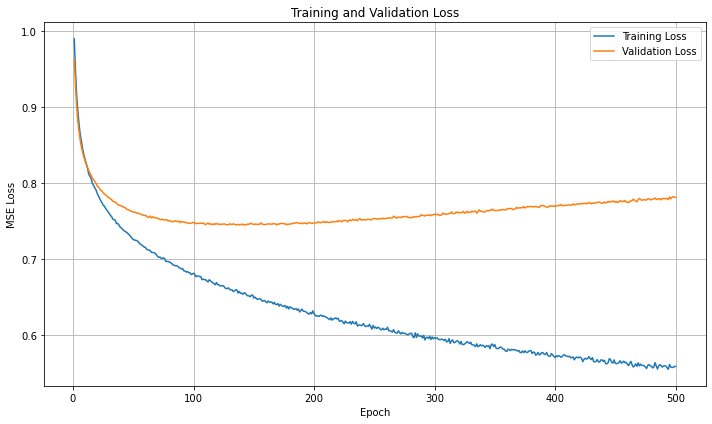

In [12]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("../../../plots/training_plot.png")
plt.show()

In [13]:
if not k_fold: 
    model.eval()
    predictions, true_values = [], []
    
    with torch.no_grad():
        for xb, yb in full_dataset:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            
            predictions.append(preds.cpu())
            true_values.append(yb.cpu())
    
    predictions = torch.cat(predictions).numpy()
    true_values = torch.cat(true_values).numpy()
    
    
    
    predictions = predictions * stds + means
    true_values = true_values * stds + means
    predictions[:, logflag] = np.exp(predictions[:, logflag])
    true_values[:, logflag] = np.exp(true_values[:, logflag])
    #additional step for second moment netowrk
    residuals = true_values - predictions

    # Variances
    variance_targets = residuals**2  

In [14]:

"""
# Covariances
from itertools import combinations

for i, j in combinations(range(all_predictions.shape[1]), 2):
    cov = residuals[:, i] * residuals[:, j]
    covariances.append(cov[:, None])
if covariances:
    covariance_targets = np.hstack(covariances)  # [N, C]
    var_targets = np.hstack([variance_targets, covariance_targets])
else:
    var_targets = variance_targets  # Only variances if 1 parameter"""


variance_targets = np.log(variance_targets)
mean = variance_targets.mean(axis = 0)
std = variance_targets.mean(axis = 0)

variance_targets = (variance_targets - mean)/std

#print(variance_targets[idx_train].mean(axis = 0))

#print(variance_targets[idx_val].mean(axis = 0))



var_targets = torch.from_numpy(variance_targets).float()



#print("training set variance: \n", variance_targets[idx_train].mean(axis = 0))

#print("validation set variance: \n" ,variance_targets[idx_val].mean(axis = 0))
print("Final target shape:", var_targets.shape)

Final target shape: torch.Size([1024, 35])


In [15]:
#now run the variance network

n_val = int(len(x) * 0.1)
perm = torch.randperm(len(x))
idx_train = perm[:-n_val]
idx_val = perm[-n_val:]


x_train, var_train = x[idx_train], var_targets[idx_train]
x_val, var_val = x[idx_val], var_targets[idx_val]




In [16]:
print(x_train.shape)

torch.Size([922, 162])


In [17]:
print(var_train.shape)

torch.Size([922, 35])


In [18]:
# Hyperparameters for variance
input_dim    = x.shape[1]
output_dim   = var_targets.shape[1]
#hidden_dims  = [128, 64]
hidden_dims  = [64, 64, 32]
#hidden_dims  = [64, 64]
lr           = 1e-4
wd           = 1e-4
dropout_rate = 0.4
epochs       = 500
val_fraction = 0.1
batch_size   = 64
separate_models = False

In [19]:

var_network = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
optimizer = optim.Adam(var_network.parameters(), lr=lr, weight_decay=wd)
criterion = MSELoss()

var_train_loader = DataLoader(TensorDataset(x_train, var_train), batch_size=batch_size, shuffle=True)
var_val_loader = DataLoader(TensorDataset(x_val, var_val), batch_size=batch_size, shuffle=False)
var_train_losses, var_val_losses = train.fit(var_network, var_train_loader, var_val_loader, optimizer, criterion, device, epochs)


Training:   0%|          | 0/500 [00:00<?, ?iter/s]

[Iter  500] validation loss: 6.2493


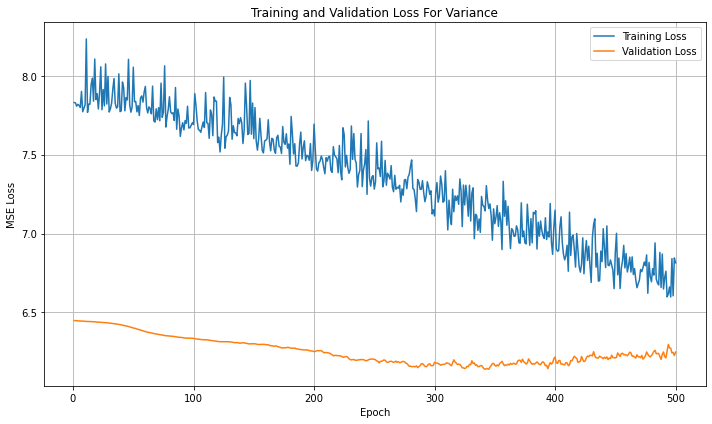

In [20]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, var_train_losses, label='Training Loss')
plt.plot(epochs_range, var_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss For Variance')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("../../training_plot_unnormalized.png")
plt.show()

In [21]:
#predictions[idx_val]

In [22]:
var_network.eval()
predicted_variances, true_variances  = [], []

with torch.no_grad():
    for xb, yb in var_val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = var_network(xb)
        
        predicted_variances.append(preds.cpu())
        true_variances.append(yb.cpu())

predicted_variances = torch.cat(predicted_variances).numpy()
true_variances = torch.cat(true_variances).numpy()



In [23]:
# Reverse the normalization
pred_log_var = predicted_variances * std + mean

# Reverse the log transform
predicted_variances = np.exp(pred_log_var)




In [24]:
all_predictions = predictions[idx_val]
all_true_values = true_values[idx_val]

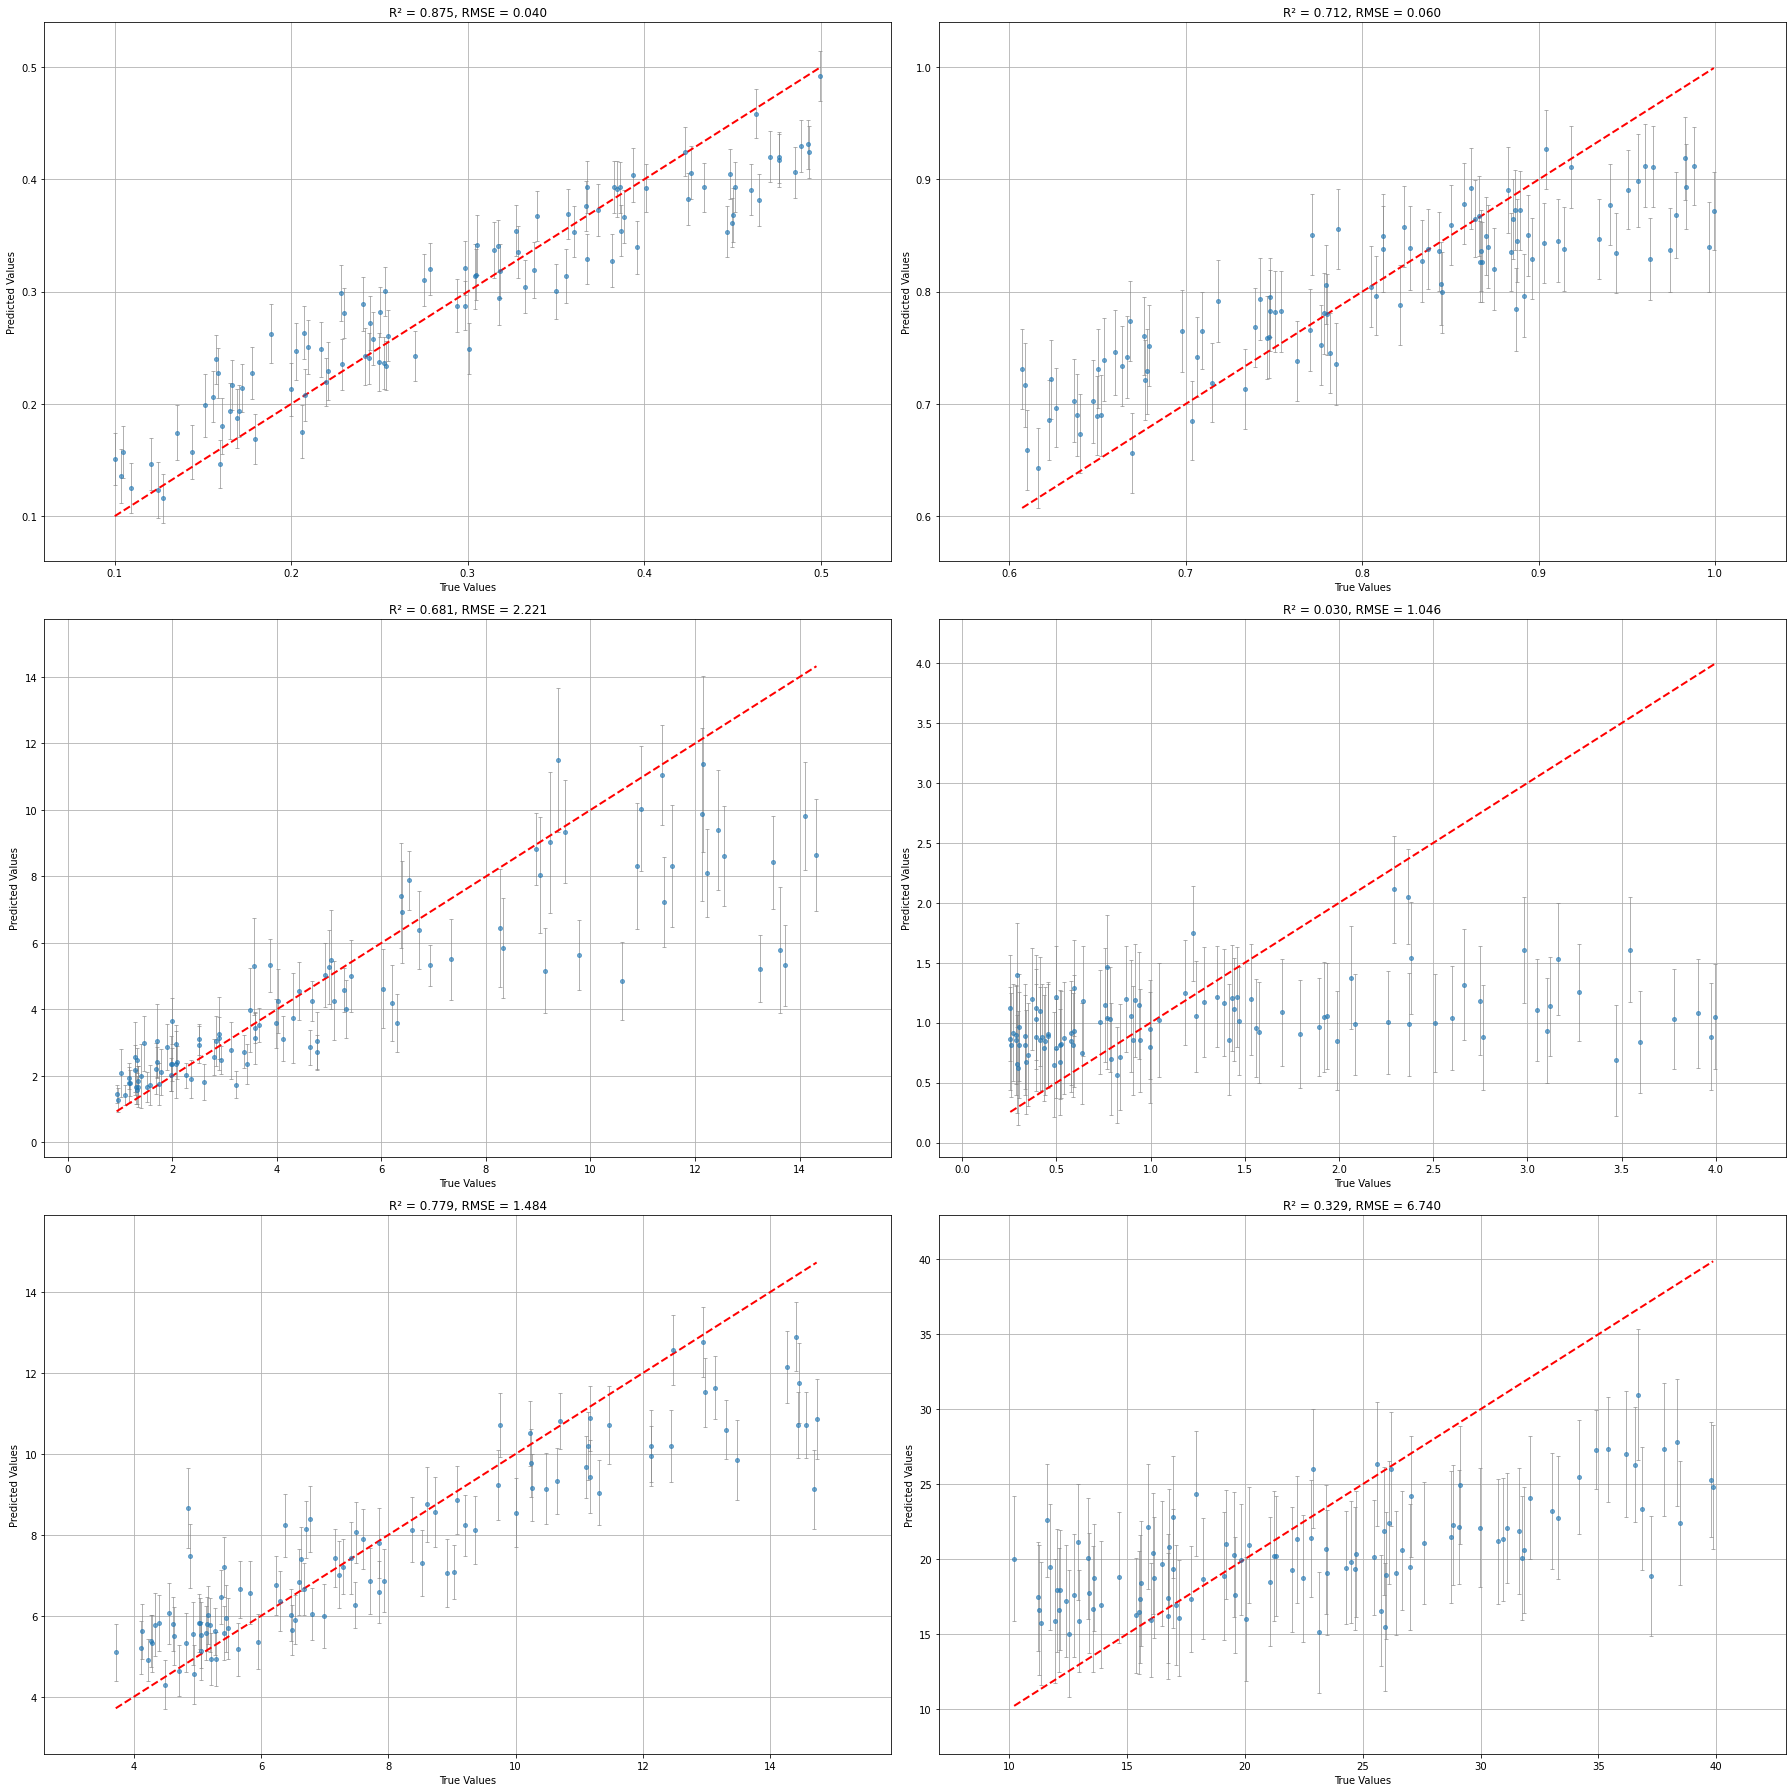

In [25]:
# Create figure with subplots
Npanels=[5,7]
#Npanels=[3,2]
fig, axes = plt.subplots(nrows=Npanels[0], ncols=Npanels[1], figsize=(25, 25))

for i in range(Npanels[0]):
    for j in range(Npanels[1]):
        ax = axes[i, j]

        idx = i * Npanels[1] + j

        predictions = all_predictions[:, idx]
        true_values = all_true_values[:, idx]
        pred_var = predicted_variances[:, idx]
        pred_std = np.sqrt(np.maximum(pred_var, 0))  # make sure variances are non-negative

        r2 = r2_score(true_values, predictions)
        rmse = np.sqrt(mean_squared_error(true_values, predictions))

        # Plot scatter with error bars in Y (predictions)
        ax.errorbar(
            true_values,              # x data
            predictions,              # y data
            yerr=pred_std,            # error bars (±1σ)
            fmt='o',                  # point marker
            alpha=0.6,
            ecolor='gray',
            elinewidth=1,
            capsize=2,
            markersize=4
        )

        # Plot ideal prediction line
        min_val = min(true_values.min(), predictions.min())
        max_val = max(true_values.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.grid(True)

        ax.set_xlim(
            origParameters.min(axis=0)[idx] - (origParameters.max(axis=0)[idx] - origParameters.min(axis=0)[idx]) * 0.1,
            origParameters.max(axis=0)[idx] + (origParameters.max(axis=0)[idx] - origParameters.min(axis=0)[idx]) * 0.1
        )
        ax.set_ylim(
            origParameters.min(axis=0)[idx] - (origParameters.max(axis=0)[idx] - origParameters.min(axis=0)[idx]) * 0.1,
            origParameters.max(axis=0)[idx] + (origParameters.max(axis=0)[idx] - origParameters.min(axis=0)[idx]) * 0.1
        )

plt.tight_layout()
plt.savefig("../../results_plot_unnormalized_with_errorbars.png")
plt.show()


In [26]:
#chi square test




chi_square = np.cumsum(variances)



NameError: name 'variances' is not defined